# Variant effect prediction

In [1]:
import warnings

warnings.filterwarnings("ignore")
from datasets import load_dataset
from functools import reduce
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
from math import sqrt
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, fisher_exact

import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    RocCurveDisplay,
    average_precision_score,
    PrecisionRecallDisplay,
)
from tqdm import tqdm

tqdm.pandas()

In [ ]:
COORDINATES = ["chrom", "pos", "ref", "alt"]


def load_models(V, dataset_path, dataset_name):
    d = Path(f"../../results/preds/{dataset_path}")
    models = dataset_models[dataset_name]
    if not isinstance(models, list):
        models = gather_unique_values(dataset_models[dataset_name])
    for m in tqdm(models):
        model_name = model_renaming.get(m, m)
        model_path = d / f"{m}.parquet"
        V = V.with_columns(
            pl.read_parquet(model_path, columns="score")["score"].alias(model_name)
        )
    return V


def get_odds_ratio(df, threshold_ns):
    rows = []
    negative_set = df.filter(~pl.col("label")).sort("score")
    for n in threshold_ns:
        threshold = negative_set[n]["score"]
        group_counts = (
            df.group_by(["label", pl.col("score") <= threshold])
            .len()
            .sort(["label", "score"])["len"]
            .to_numpy()
            .reshape((2, 2))
        )
        odds_ratio, p_value = fisher_exact(group_counts, alternative="greater")
        rows.append([n, odds_ratio, p_value])
    # in updated polars, might need to add orient="row"
    return pl.DataFrame(rows, schema=["n", "Odds ratio", "p_value"])


def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.

    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f"{num / 1e9:.1f}B"
    elif num >= 1e6:
        return f"{num / 1e6:.1f}M"
    elif num >= 1e3:
        return f"{num / 1e3:.1f}K"
    else:
        return str(num)


def plot_curve(V, results, curve, title, save_path=None):
    n_pos, n_neg = results.n_pos.iloc[0], results.n_neg.iloc[0]
    sample_size = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
    title = f"{title}\n{sample_size}"
    if curve == "ROC":
        plot_f = RocCurveDisplay
        metric = "AUROC"
        xlabel = "False Positive Rate"
        ylabel = "True Positive Rate"
        random_plot = lambda ax: ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
    elif curve == "PR":
        pos_prop = n_pos / (n_pos + n_neg)
        plot_f = PrecisionRecallDisplay
        metric = "AUPRC"
        xlabel = "Recall"
        ylabel = "Precision"
        random_plot = lambda ax: ax.axhline(y=pos_prop, linestyle="--", color="gray")

    # note: latest sklearn has argument: plot_chance_level
    fig, ax = plt.subplots(figsize=(3, 3))

    for m in results.Model.unique()[::-1]:
        AUC = results[results.Model == m].iloc[0][metric]
        plot_f.from_predictions(
            V.label,
            -V[m],
            name=m,
            ax=ax,
            label=f"{m} (AUC={AUC:.3f})",
            color=palette[m],
        )

    random_plot(ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    sns.despine()

    ax.legend()
    # get handles and labels
    handles, labels = ax.get_legend_handles_labels()
    # reverse the order
    handles, labels = handles[::-1], labels[::-1]
    # create the legend with the reversed order
    ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))

    plt.title(title)
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")


color_neg = sns.color_palette("Dark2")[0]
color_pos = sns.color_palette("Dark2")[1]
palette_label = {
    "gnomAD/\nCommon": color_neg,
    "ClinVar/\nPathogenic": color_pos,
    "COSMIC/\nFrequent": color_pos,
    "OMIM/\nPathogenic": color_pos,
    "gnomAD/\nRare": color_pos,
    "Common": color_neg,
    "Rare": color_pos,
}


def barplot(
    df,
    metric,
    title,
    groupby="Consequence",
    width=2,
    height=2,
    nrows=1,
    ncols=1,
    save_path=None,
    wspace=None,
    hspace=None,
    x=None,
    y=None,
):
    if groupby not in df.columns:
        df[groupby] = "all"
    groups = df[groupby].unique()
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        sharex=False,
        sharey=False,
        figsize=(width * ncols, height * nrows),
        squeeze=False,
        gridspec_kw={"wspace": wspace, "hspace": hspace},
    )

    for group, ax in zip(groups, axes.flat):
        df_g = df[df[groupby] == group].sort_values(metric, ascending=False)
        n_pos, n_neg = df_g.n_pos.iloc[0], df_g.n_neg.iloc[0]

        if metric == "AUROC":
            baseline = 0.5
        elif metric == "AUPRC":
            baseline = n_pos / (n_pos + n_neg)
        elif metric == "Odds ratio":
            baseline = 1

        g = sns.barplot(
            data=df_g,
            y="Model",
            x=metric,
            palette=palette,
            ax=ax,
        )
        sns.despine()
        sample_size = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
        subtitle = f"{group}\n{sample_size}" if len(groups) > 1 else sample_size
        g.set_title(subtitle, fontsize=10)
        g.set(xlim=baseline, ylabel="")

        for bar, model in zip(g.patches, df_g.Model):
            if metric == "Odds ratio":
                text = f"{bar.get_width():.1f}"
                if df_g[df_g.Model == model].p_value.iloc[0] >= 0.05:
                    text = text + " (NS)"
            else:
                text = f"{bar.get_width():.3f}"

            g.text(
                max(
                    bar.get_width(), baseline
                ),  # X position, here at the end of the bar
                bar.get_y()
                + bar.get_height() / 2,  # Y position, in the middle of the bar
                text,  # Text to be displayed, formatted to 3 decimal places
                va="center",  # Vertical alignment
            )

        # if metric == "Odds ratio":
        #    for index, row in df_g.iterrows():
        #        if row['p_value'] >= 0.05:
        #            g.text(y=index, x=row['Odds ratio'], s='(ns)', ha='right')

    plt.suptitle(title, x=x, y=y, fontsize=11)
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")


def histplot_label(V, label_pos, label_neg, save_path=None, **kwargs):
    V["label"] = V.label.replace({True: label_pos, False: label_neg})
    plt.figure(figsize=(3, 3))
    g = sns.histplot(
        data=V,
        x="GPN-MSA",
        hue="label",
        hue_order=[label_pos, label_neg],
        bins=25,
        stat="density",
        common_norm=False,
        common_bins=True,
        palette=palette_label,
        **kwargs,
    )
    sns.despine()
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")


def ecdfplot_label(V, save_path=None, **kwargs):
    plt.figure(figsize=(3, 3))
    sns.ecdfplot(
        data=V,
        x="GPN-MSA",
        hue="label",
        palette=palette_label,
        **kwargs,
    )
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

In [3]:
plot_dir = "../../results/plots/"

In [4]:
palette = {
    "GPN-MSA": "C0",
    "CADD": "C1",
    "phyloP": "C2",
    "ESM-1b": "C3",
    "NT": "C4",
    "SpliceAI": "C5",
    "Enformer": "C6",
    "HyenaDNA": "C9",
    "phyloP-100v": "C2",
    "phyloP-241m": "C7",
    "phastCons-100v": "C8",
    "NT-500m-human-ref": "gray",
    "NT-500m-1000g": "gray",
    "NT-2.5b-1000g": "gray",
    "NT-2.5b-multi-species": "C4",
    r"Enformer ($L^1$)": "C6",
    r"Enformer ($L^2$)": "C7",
    r"Enformer ($L^\infty$)": "C8",
    "PrimateAI-3D": "black",
    "pLI": "C6",
    r"$hs$": "C9",
    "GeneBayes": "teal",
}

In [5]:
core_models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "CADD.RawScore",
    "phyloP",
    "phyloP-Zoonomia",
    "phastCons",
]

nt_model = "InstaDeepAI/nucleotide-transformer-2.5b-multi-species"
hyenadna_model = "LongSafari/hyenadna-large-1m-seqlen-hf"

ablation_models = (
    pd.read_csv("../../ablation_models.txt", header=None).values.ravel().tolist()[1:]
)
ablation_models = []

original_name = "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True"

model_renaming = {
    # GPN-MSA
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    # HyenaDNA models
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    # Other models
    "CADD.RawScore": "CADD",
    "phyloP": "phyloP-100v",
    "phastCons": "phastCons-100v",
    "phyloP-Zoonomia": "phyloP-241m",
}


def gather_unique_values(d):
    unique_values = []
    seen = set()

    def gather_values(nested_dict):
        for value in nested_dict.values():
            if isinstance(value, dict):
                gather_values(value)
            elif isinstance(value, list):
                for item in value:
                    if item not in seen:
                        unique_values.append(item)
                        seen.add(item)

    gather_values(d)

    return unique_values


def apply_to_values(d, f):
    for key, value in d.items():
        if isinstance(value, dict):
            apply_to_values(value, f)
        elif isinstance(value, list):
            d[key] = [f(x) for x in value]
        else:
            d[key] = f(value)


consequence_bundles = {
    "splice_region": [
        "splice_polypyrimidine_tract",
        "splice_region",
        "splice_donor_region",
        "splice_donor",
        "splice_donor_5th_base",
        "splice_acceptor",
    ],
    "start_or_stop": {
        "stop_gained",
        "stop_lost",
        "start_lost",
    },
}

dataset_models = {
    "ClinVar": core_models
    + ["ESM-1b", nt_model, hyenadna_model]
    + ablation_models,  # + ["PrimateAI-3D"],
    "COSMIC": core_models + ["ESM-1b"] + ablation_models,  # + ["PrimateAI-3D"],
    "OMIM": {
        "all": core_models + ablation_models,
        "Promoter": core_models + [nt_model],
        "Enhancer": core_models,
        "5' UTR": core_models + [nt_model],
        "3' UTR": core_models + [nt_model],
        "ncRNA": core_models + [nt_model],
    },
    "gnomAD": {
        "all": core_models,
        # "missense": core_models + ["ESM-1b"], # + ["PrimateAI-3D"],
        # "synonymous": core_models,
        # "5_prime_UTR": core_models,
        # "3_prime_UTR": core_models,
        # "upstream_gene": core_models,
        # "downstream_gene": core_models,
        # "intron": core_models + ["SpliceAI"],
        # "intergenic": core_models,
        # "non_coding_transcript_exon": core_models,
        # "splice_region": core_models + ["SpliceAI"],
        # "start_or_stop": core_models,
    },
    "gnomAD_Enformer": core_models + ["Enformer_l1", "Enformer_l2", "Enformer_linf"],
    "gnomAD_ablation": core_models[:1] + ablation_models,
    "ClinVar_benign": core_models + ["ESM-1b"],
    "ClinVar_likely": core_models + ["ESM-1b"],
    "DMS": core_models + ["ESM-1b"],
}

In [6]:
dataset_path = "results/clinvar/merged"
V_clinvar = pl.read_parquet(
    f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"]
).with_columns(pl.col("label") == "Pathogenic")
V_clinvar = load_models(V_clinvar, dataset_path, "ClinVar").unique(
    COORDINATES, keep="none", maintain_order=True
)

100%|██████████| 8/8 [00:00<00:00, 196.25it/s]


In [7]:
dataset_path = "results/cosmic/merged"
V_cosmic = pl.read_parquet(
    f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"]
).with_columns(pl.col("label") == "Frequent")
V_cosmic = load_models(V_cosmic, dataset_path, "COSMIC").unique(
    COORDINATES, keep="none", maintain_order=True
)

100%|██████████| 6/6 [00:00<00:00, 397.39it/s]


In [8]:
dataset_path = "results/omim/merged"
V_omim = pl.read_parquet(
    f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label", "consequence"]
).with_columns(pl.col("label") == "Pathogenic")
V_omim = load_models(V_omim, dataset_path, "OMIM").unique(
    COORDINATES, keep="none", maintain_order=True
)

100%|██████████| 6/6 [00:00<00:00, 35.87it/s]


In [9]:
dataset_path = "results/gnomad/merged/filt"
V_gnomad = pl.read_parquet(
    f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label", "consequence"]
).with_columns(
    pl.col("label") == "Rare",
    pl.col("consequence").str.replace("_variant", ""),
)
for new_c, old_cs in consequence_bundles.items():
    V_gnomad = V_gnomad.with_columns(
        pl.when(pl.col("consequence").is_in(old_cs))
        .then(pl.lit(new_c))
        .otherwise(pl.col("consequence"))
        .alias("consequence")
    )
V_gnomad = load_models(V_gnomad, dataset_path, "gnomAD")

100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


In [ ]:
dataset_path = "results/variants_enformer/"
V_enformer = pl.read_parquet(
    f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"]
).with_columns(pl.col("label") == "Low-frequency")
V_enformer = load_models(V_enformer, dataset_path, "gnomAD_Enformer").unique(
    COORDINATES
)

100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


In [11]:
dataset_path = "results/gnomad/merged/subsampled"
V_gnomad_ablation = pl.read_parquet(
    f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"]
).with_columns(pl.col("label") == "Rare")
V_gnomad_ablation = load_models(
    V_gnomad_ablation, dataset_path, "gnomAD_ablation"
).unique(COORDINATES)

100%|██████████| 47/47 [00:23<00:00,  2.01it/s]


In [6]:
dataset_path = "results/clinvar/mis_pat_ben"
V_clinvar_benign = pl.read_parquet(
    f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"]
).with_columns(pl.col("label") == "Pathogenic")
V_clinvar_benign = load_models(V_clinvar_benign, dataset_path, "ClinVar_benign").unique(
    COORDINATES
)

100%|██████████| 6/6 [00:00<00:00, 28.86it/s]


In [6]:
dataset_path = "results/clinvar/likely"
V_clinvar_likely = pl.read_parquet(
    f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label"]
).with_columns(pl.col("label").is_in(["Pathogenic", "Likely_pathogenic"]))
V_clinvar_likely = load_models(V_clinvar_likely, dataset_path, "ClinVar_likely").unique(
    COORDINATES
)

100%|██████████| 6/6 [00:00<00:00, 102.75it/s]


In [102]:
dataset_path = "results/dms/merged"
V_dms = pl.read_parquet(
    f"../../{dataset_path}/test.parquet", columns=COORDINATES + ["label", "DMS"]
)
V_dms = load_models(V_dms, dataset_path, "DMS")

100%|██████████| 5/5 [00:00<00:00, 308.67it/s]


In [112]:
# dataset_path = "results/dms/merged"
dataset_path = "results/dms2/snv"
V_dms = (
    pl.read_parquet(
        f"../../{dataset_path}/test.parquet"
    )  # , columns=COORDINATES + ["label", "DMS"])
)
V_dms = load_models(V_dms, dataset_path, "DMS")

100%|██████████| 6/6 [00:00<00:00, 91.05it/s]


In [7]:
apply_to_values(dataset_models, lambda m: model_renaming.get(m, m))

## ClinVar pathogenic vs. gnomAD common (missense)

In [11]:
models_clinvar = dataset_models["ClinVar"]
V_clinvar = V_clinvar.drop_nulls(subset=models_clinvar)
n_pos, n_neg = V_clinvar["label"].sum(), (~V_clinvar["label"]).sum()
rows = []
for m in tqdm(models_clinvar):
    y_true = V_clinvar["label"]
    y_score = -V_clinvar[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append(["all", m, AUROC, AUPRC, n_pos, n_neg])
results_clinvar = pd.DataFrame(
    rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"]
).sort_values("AUROC", ascending=False)
results_clinvar.head()

100%|██████████| 8/8 [00:00<00:00, 36.59it/s]


,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
0,all,GPN-MSA,0.968525,0.975992,21273,15402
1,all,CADD,0.962982,0.968901,21273,15402
5,all,ESM-1b,0.943750,0.962551,21273,15402
2,all,phyloP-100v,0.923292,0.941895,21273,15402
3,all,phyloP-241m,0.904597,0.916929,21273,15402


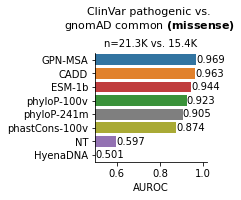

In [22]:
barplot(
    results_clinvar[~results_clinvar.Model.isin(ablation_models)],
    "AUROC",
    "ClinVar pathogenic vs.\ngnomAD common " + r"$\mathbf{(missense)}$",
    y=1.2,
    # save_path="clinvar_auroc.svg",
)

In [14]:
"""
barplot(
    results_clinvar[~results_clinvar.Model.isin(ablation_models)],
    "AUROC",
    "ClinVar pathogenic vs.\ngnomAD common (missense)",
    y=1.2,
    #save_path="clinvar_auroc_primateai.svg",
)
""";

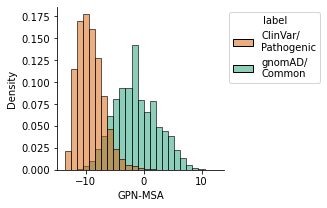

In [20]:
histplot_label(
    V_clinvar.select(["label", "GPN-MSA"]).to_pandas(),
    "ClinVar/\nPathogenic",
    "gnomAD/\nCommon",
    # save_path="hist_clinvar.svg",
)

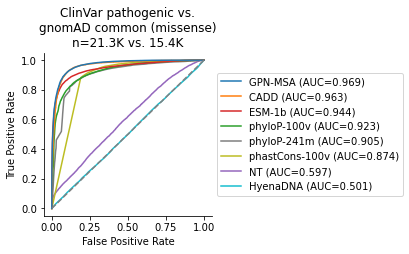

In [22]:
plot_curve(
    V_clinvar.to_pandas(),
    results_clinvar[~results_clinvar.Model.isin(ablation_models)],
    "ROC",
    "ClinVar pathogenic vs.\ngnomAD common (missense)",
    # save_path="clinvar_roc.svg",
)

### Stratifying by conservation

In [23]:
conservation_model = "phyloP-241m"
log_pval_thresh = -np.log10(0.05)  # 1.3
V_clinvar = V_clinvar.with_columns(
    pl.when(pl.col(conservation_model) < -log_pval_thresh)
    .then(pl.lit("conserved"))
    .when(pl.col(conservation_model) > log_pval_thresh)
    .then(pl.lit("accelerated"))
    .otherwise(pl.lit("neutral"))
    .alias("conservation")
)
V_clinvar["conservation"].value_counts()

conservation,count
str,u32
"""accelerated""",2037
"""conserved""",26652
"""neutral""",7986


In [24]:
rows = []
for c in ["all"] + list(V_clinvar["conservation"].unique()):
    V_c = V_clinvar if c == "all" else V_clinvar.filter(conservation=c)
    n_pos, n_neg = V_c["label"].sum(), (~V_c["label"]).sum()
    y_true = V_c["label"]
    for m in [m for m in models_clinvar if m not in ablation_models]:
        y_score = -V_c[m]
        AUROC = roc_auc_score(y_true, y_score)
        AUPRC = average_precision_score(y_true, y_score)
        rows.append([c, m, AUROC, AUPRC, n_pos, n_neg])
# Conservation called "Consequence" for plotting function convenience
results_clinvar_strat = pd.DataFrame(
    rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"]
)
results_clinvar_strat.head()

,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
0,all,GPN-MSA,0.968525,0.975992,21273,15402
1,all,CADD,0.962982,0.968901,21273,15402
2,all,phyloP-100v,0.923292,0.941895,21273,15402
3,all,phyloP-241m,0.904597,0.916929,21273,15402
4,all,phastCons-100v,0.873833,0.855832,21273,15402


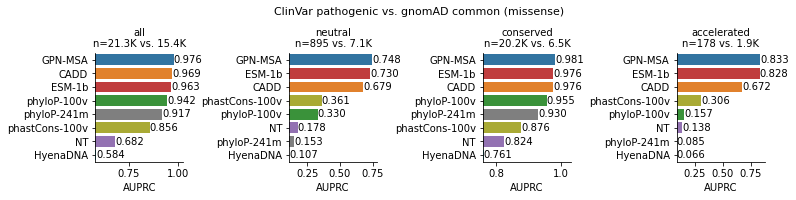

In [26]:
barplot(
    results_clinvar_strat,
    "AUPRC",
    "ClinVar pathogenic vs. gnomAD common (missense)",
    ncols=4,
    wspace=1.2,
    width=3,
    y=1.2,
    # save_path="clinvar_strat_auprc.svg",
)

## COSMIC frequent vs. gnomAD common (missense)

In [23]:
models_cosmic = dataset_models["COSMIC"]
V_cosmic = V_cosmic.drop_nulls(subset=models_cosmic)
n_pos, n_neg = V_cosmic["label"].sum(), (~V_cosmic["label"]).sum()
rows = []
for m in tqdm(models_cosmic):
    y_true = V_cosmic["label"]
    y_score = -V_cosmic[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append(["all", m, AUROC, AUPRC, n_pos, n_neg])
results_cosmic = pd.DataFrame(
    rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"]
).sort_values("AUPRC", ascending=False)
results_cosmic.head()

100%|██████████| 6/6 [00:00<00:00, 109.28it/s]


,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
0,all,GPN-MSA,0.776506,0.354610,183,15399
5,all,ESM-1b,0.791081,0.213785,183,15399
1,all,CADD,0.761977,0.166532,183,15399
2,all,phyloP-100v,0.693006,0.140929,183,15399
3,all,phyloP-241m,0.683706,0.089280,183,15399


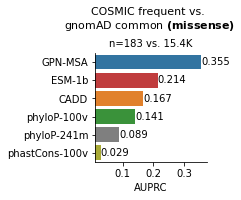

In [25]:
barplot(
    results_cosmic[~results_cosmic.Model.isin(ablation_models)],
    "AUPRC",
    "COSMIC frequent vs. \ngnomAD common " + r"$\mathbf{(missense)}$",
    y=1.2,
    # save_path="cosmic_auprc.svg",
)

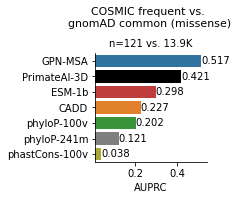

In [17]:
"""
barplot(
    results_cosmic[~results_cosmic.Model.isin(ablation_models)],
    "AUPRC",
    "COSMIC frequent vs. \ngnomAD common (missense)",
    y=1.2,
    #save_path="cosmic_auprc_primateai.svg",
)
""";

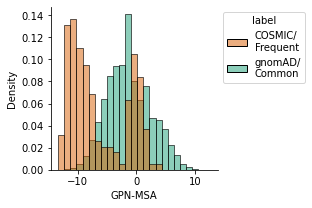

In [30]:
histplot_label(
    V_cosmic.select(["label", "GPN-MSA"]).to_pandas(),
    "COSMIC/\nFrequent",
    "gnomAD/\nCommon",
    # save_path="hist_cosmic.svg",
)

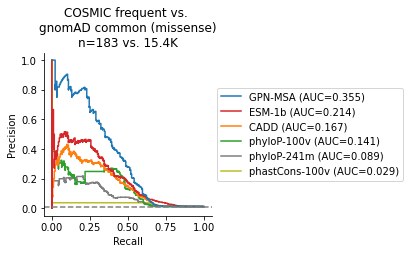

In [31]:
plot_curve(
    V_cosmic.to_pandas(),
    results_cosmic[~results_cosmic.Model.isin(ablation_models)],
    "PR",
    "COSMIC frequent vs. \ngnomAD common (missense)",
    # save_path="cosmic_pr_curve.svg",
)

## OMIM pathogenic vs. gnomAD common (regulatory)

In [22]:
consequence_models = dataset_models["OMIM"]
rows = []
for c in tqdm(consequence_models):
    V_c = V_omim if c == "all" else V_omim.filter(consequence=c)
    V_c = V_c.drop_nulls(subset=consequence_models[c])
    n_pos, n_neg = V_c["label"].sum(), (~V_c["label"]).sum()
    y_true = V_c["label"]
    for m in consequence_models[c]:
        y_score = -V_c[m]
        AUROC = roc_auc_score(y_true, y_score)
        AUPRC = average_precision_score(y_true, y_score)
        rows.append([c, m, AUROC, AUPRC, n_pos, n_neg])
results_omim = pd.DataFrame(
    rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"]
)
results_omim.head()

100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
0,all,GPN-MSA,0.930498,0.127152,406,2573918
1,all,CADD,0.939016,0.048271,406,2573918
2,all,phyloP-100v,0.871816,0.037942,406,2573918
3,all,phyloP-241m,0.884964,0.028139,406,2573918
4,all,phastCons-100v,0.830174,0.005947,406,2573918


In [23]:
results_omim.Consequence = results_omim.Consequence.replace(
    {
        "Promoter": "promoter",
        "Enhancer": "enhancer",
    }
)

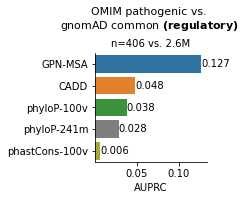

In [25]:
barplot(
    results_omim[
        ~results_omim.Model.isin(ablation_models) & (results_omim.Consequence == "all")
    ],
    "AUPRC",
    "OMIM pathogenic vs.\ngnomAD common " + r"$\mathbf{(regulatory)}$",
    y=1.2,
    # save_path="omim_auprc.svg",
)

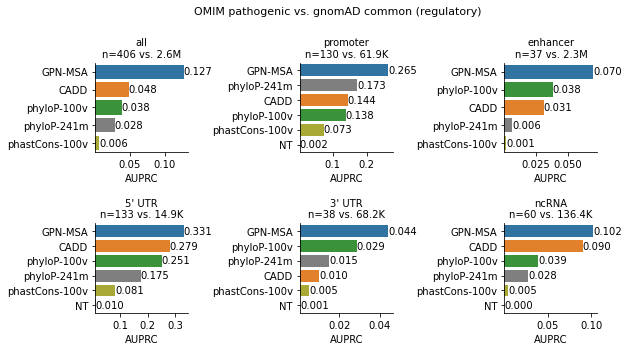

In [48]:
barplot(
    results_omim[~results_omim.Model.isin(ablation_models)],
    "AUPRC",
    "OMIM pathogenic vs. gnomAD common (regulatory)",
    nrows=2,
    ncols=3,
    hspace=0.8,
    wspace=1.2,
    width=3,
    height=2.3,
    y=1.05,
    # save_path="omim_auprc_full.pdf",
)

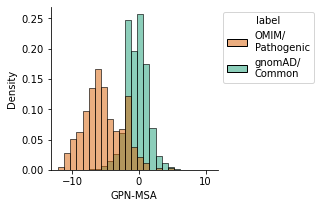

In [37]:
histplot_label(
    V_omim.select(["label", "GPN-MSA"]).to_pandas(),
    "OMIM/\nPathogenic",
    "gnomAD/\nCommon",
    # save_path="hist_omim.svg",
)

In [38]:
def omim_curve_plot(
    save_path=None,
    title="OMIM pathogenic vs. gnomAD common (regulatory)",
    x=None,
    y=1.03,
):
    consequence_models = dataset_models["OMIM"]
    plot_f = PrecisionRecallDisplay
    metric = "AUPRC"
    xlabel = "Recall"
    ylabel = "Precision"
    pos_label = "Pathogenic"

    fig, axes = plt.subplots(
        nrows=2,
        ncols=3,
        sharex=True,
        sharey=True,
        figsize=(11, 5.5),
    )

    rows = []
    i = 0
    for c in consequence_models:
        ax = axes.flat[i]
        V_c = (
            V_omim.to_pandas()
            if c == "all"
            else V_omim.filter(consequence=c).to_pandas()
        )
        V_c.dropna(subset=consequence_models[c], inplace=True)

        n_pos, n_neg = V_c.label.sum(), (~V_c.label).sum()
        pos_prop = n_pos / (n_pos + n_neg)
        sample_size = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
        subtitle = f"{c}\n{sample_size}"

        for m in np.array(consequence_models[c])[::-1]:
            if m in ablation_models:
                continue
            if m in ["NT", "phastCons-100v"]:
                continue
            AUC = average_precision_score(V_c.label, -V_c[m])
            plot_f.from_predictions(
                V_c.label,
                -V_c[m],
                name=m,
                ax=ax,
                label=f"{m}\n(AUC={AUC:.3f})",
                color=palette[m],
            )

        ax.axhline(y=pos_prop, linestyle="--", color="gray")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        sns.despine()

        ax.legend()
        # get handles and labels
        handles, labels = ax.get_legend_handles_labels()
        # reverse the order
        handles, labels = handles[::-1], labels[::-1]
        # create the legend with the reversed order
        ax.legend(
            handles, labels, fontsize=8
        )  # loc='center left', bbox_to_anchor=(1, 0.5))

        ax.set_title(subtitle)
        i += 1

    fig.suptitle(title, y=y, fontsize=12, x=x)
    plt.subplots_adjust(hspace=0.5)

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

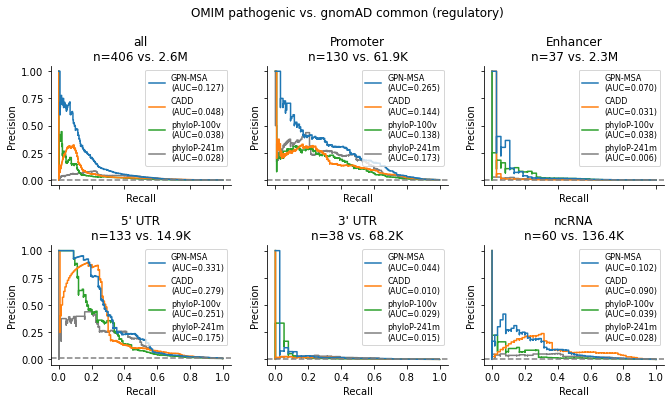

In [39]:
omim_curve_plot(
    # save_path="omim_pr_curves.svg",
)

### Specific examples

In [12]:
dataset_models["OMIM"]["Enhancer"]

['GPN-MSA', 'CADD', 'phyloP-100v', 'phyloP-241m', 'phastCons-100v']

In [23]:
df = V_omim.filter(consequence="Enhancer")
for m in dataset_models["OMIM"]["Enhancer"]:
    df = df.with_columns(pl.col(m).rank())
df = df.filter(pl.col("label"), pl.col("chrom") == "7")
df = df.filter(
    pl.col("GPN-MSA") == df.select(dataset_models["OMIM"]["Enhancer"]).min_horizontal()
).sort("GPN-MSA")
df

chrom,pos,ref,alt,label,consequence,GPN-MSA,CADD,phyloP-100v,phyloP-241m,phastCons-100v,NT
str,i64,str,str,bool,str,f64,f64,f64,f64,f64,f32
"""7""",156791472,"""C""","""G""",true,"""Enhancer""",5.0,11288.0,47.5,74.5,7068.5,null
"""7""",156791542,"""A""","""C""",true,"""Enhancer""",11.0,7025.0,19.0,6856.0,7068.5,null
"""7""",156791472,"""C""","""T""",true,"""Enhancer""",44.5,10155.0,47.5,74.5,7068.5,null
"""7""",156791571,"""T""","""A""",true,"""Enhancer""",86.5,57749.0,119634.5,1077735.5,14750.5,null
"""7""",156791579,"""C""","""T""",true,"""Enhancer""",1084.5,46842.0,2101.5,10159.0,16115.0,null
"""7""",156791459,"""T""","""C""",true,"""Enhancer""",1410.5,7827.0,1644.5,3513.0,7068.5,null
"""7""",156791413,"""A""","""C""",true,"""Enhancer""",6588.5,33263.0,30514.0,657366.5,7068.5,null


In [24]:
examples = [
    (156_791_542, "Enhancer"),
    (113_105_781, "Promoter"),
    (22_130_605, "5' UTR"),
]

for pos, consequence in examples:
    print(pos, consequence)
    models = dataset_models["OMIM"][consequence]
    df = V_omim.filter(consequence=consequence).drop_nulls(subset=models)
    df = df.with_columns(pl.col(models).rank() / len(df) * 100)
    df = (
        df.filter(pos=pos)
        .select(models)
        .transpose(include_header=True)
        .sort("column_0")
    )
    df = df.with_columns(
        pl.col("column")
        + " -- "
        + pl.col("column_0").round_sig_figs(1).cast(str)
        + "\%"
    )
    print(", ".join(df["column"]))

156791542 Enhancer
GPN-MSA -- 0.0005\%, phyloP-100v -- 0.0008\%, phyloP-241m -- 0.3\%, CADD -- 0.3\%, phastCons-100v -- 0.3\%
113105781 Promoter
GPN-MSA -- 0.01\%, phyloP-100v -- 0.3\%, phastCons-100v -- 0.5\%, CADD -- 0.8\%, phyloP-241m -- 0.9\%, NT -- 30.0\%
22130605 5' UTR
CADD -- 0.2\%, GPN-MSA -- 0.3\%, phyloP-241m -- 1.0\%, phastCons-100v -- 2.0\%, phyloP-100v -- 6.0\%, NT -- 90.0\%


## gnomAD rare vs. common

In [11]:
consequence_models = dataset_models["gnomAD"]
results_gnomad = []
for c in tqdm(list(consequence_models.keys())):
    if c != "all":
        continue
    df_c = V_gnomad if c == "all" else V_gnomad.filter(consequence=c)
    df_c = df_c.drop_nulls(subset=consequence_models[c])
    n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
    for m in consequence_models[c]:
        odds_ratio = get_odds_ratio(
            df_c.select(["label", pl.col(m).alias("score")]), [30, 60, 90]
        ).with_columns(
            Consequence=pl.lit(c),
            Model=pl.lit(m),
            n_pos=pl.lit(n_pos),
            n_neg=pl.lit(n_neg),
        )
        results_gnomad.append(odds_ratio)
results_gnomad = pl.concat(results_gnomad).to_pandas()
results_gnomad.head()

100%|██████████| 1/1 [01:35<00:00, 95.19s/it]


,n,Odds ratio,p_value,Consequence,Model,n_pos,n_neg
0,30,103.725214,0.000000e+00,all,GPN-MSA,252706195,5894721
1,60,76.681433,0.000000e+00,all,GPN-MSA,252706195,5894721
2,90,62.576950,0.000000e+00,all,GPN-MSA,252706195,5894721
3,30,17.571563,6.150975e-184,all,CADD,252706195,5894721
4,60,16.612214,0.000000e+00,all,CADD,252706195,5894721


In [12]:
replacements = {
    "5_prime_UTR": "5' UTR",
    "3_prime_UTR": "3' UTR",
    "upstream_gene": "upstream-of-gene",
    "downstream_gene": "downstream-of-gene",
    "non_coding_transcript_exon": "ncRNA",
    "splice_region": "splice-region",
    "start_or_stop": "start-or-stop",
}
results_gnomad["Consequence"] = results_gnomad["Consequence"].replace(replacements)

In [13]:
(
    results_gnomad[
        (results_gnomad.n == 30) & ~results_gnomad.Model.isin(ablation_models)
    ].p_value
    < 0.05
).value_counts()

p_value
True    5
Name: count, dtype: int64

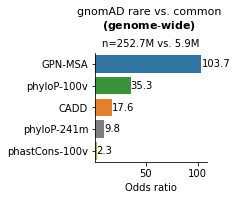

In [21]:
barplot(
    results_gnomad[
        (results_gnomad.n == 30)
        & (results_gnomad.p_value < 0.05)
        & ~results_gnomad.Model.isin(ablation_models)
        & (results_gnomad.Consequence == "all")
    ],
    "Odds ratio",
    # "gnomAD rare vs. common\n" + r'$\mathbf{(genomewide)}$',
    "gnomAD rare vs. common\n" + r"$\mathbf{(genome}$" + "-" + r"$\mathbf{wide)}$",
    y=1.2,
    # save_path="gnomad_or.svg",
)

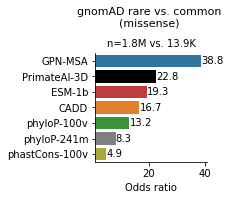

In [24]:
"""
barplot(
    results_gnomad[
        (results_gnomad.n==30) &
        (results_gnomad.p_value < 0.05) &
        ~results_gnomad.Model.isin(ablation_models) &
        (results_gnomad.Consequence == "missense")
    ],
    "Odds ratio",
    "gnomAD rare vs. common\n(missense)",
    y=1.2,
    save_path="gnomad_or_primateai.svg",
)
""";

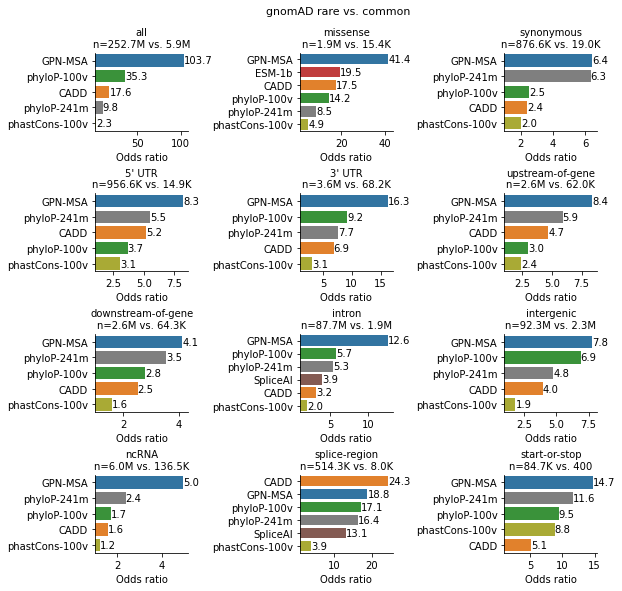

In [60]:
barplot(
    results_gnomad[
        (results_gnomad.n == 30)
        & (results_gnomad.p_value < 0.05)
        & ~results_gnomad.Model.isin(ablation_models)
    ],
    "Odds ratio",
    "gnomAD rare vs. common",
    nrows=4,
    ncols=3,
    hspace=0.8,
    wspace=1.2,
    width=3,
    height=2.3,
    y=0.95,
    # save_path="gnomad_or_full.pdf",
)

In [51]:
def get_subtitle(x):
    sample_size = f"n={format_number(x.n_pos)} vs. {format_number(x.n_neg)}"
    return f"{x.Consequence}\n{sample_size}"


results_gnomad["subtitle"] = results_gnomad.apply(get_subtitle, axis=1)

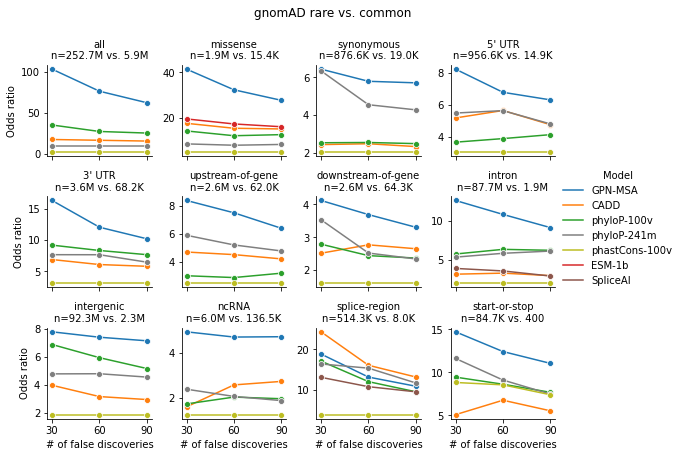

In [97]:
g = sns.relplot(
    data=results_gnomad[results_gnomad.p_value <= 0.05].rename(
        columns={"n": "# of false discoveries"}
    ),
    x="# of false discoveries",
    y="Odds ratio",
    hue="Model",
    col="subtitle",
    kind="line",
    marker="o",
    height=2,
    col_wrap=4,
    facet_kws={"sharey": False, "sharex": True},
    palette=palette,
    # markersize=5,
)
g.set(xticks=[30, 60, 90])
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.suptitle("gnomAD rare vs. common", y=1.05);
# plt.savefig(plot_dir + "gnomad_or_line.pdf", bbox_inches="tight")

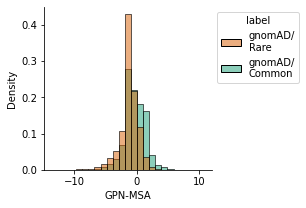

In [57]:
histplot_label(
    V_gnomad.select(["label", "GPN-MSA"]).sample(n=10_000_000, seed=42).to_pandas(),
    "gnomAD/\nRare",
    "gnomAD/\nCommon",
    # save_path="hist_gnomad.svg",
)

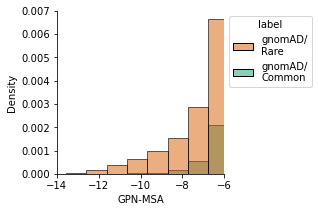

In [58]:
histplot_label(
    V_gnomad.select(["label", "GPN-MSA"]).sample(n=10_000_000, seed=42).to_pandas(),
    "gnomAD/\nRare",
    "gnomAD/\nCommon",
)
plt.xlim(-14, -6)
plt.ylim(0, 7e-3)
# plt.savefig(plot_dir + "hist_gnomad_zoom.svg", bbox_inches="tight")

### Stratifying by conservation

In [59]:
conservation_model = "phyloP-241m"
log_pval_thresh = -np.log10(0.05)  # 1.3
models_gnomad_strat = [
    m for m in dataset_models["gnomAD"]["all"] if m not in ablation_models
]
V_gnomad_strat = V_gnomad.drop_nulls(subset=models_gnomad_strat).with_columns(
    pl.when(pl.col(conservation_model) < -log_pval_thresh)
    .then(pl.lit("conserved"))
    .when(pl.col(conservation_model) > log_pval_thresh)
    .then(pl.lit("accelerated"))
    .otherwise(pl.lit("neutral"))
    .alias("conservation")
)
V_gnomad_strat["conservation"].value_counts()

conservation,count
str,u32
"""conserved""",18036217
"""accelerated""",21511215
"""neutral""",219053484


In [60]:
results_gnomad_strat = []
for c in tqdm(["all"] + list(V_gnomad_strat["conservation"].unique())):
    df_c = V_gnomad_strat if c == "all" else V_gnomad_strat.filter(conservation=c)
    n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
    for m in models_gnomad_strat:
        odds_ratio = get_odds_ratio(
            df_c.select(["label", pl.col(m).alias("score")]), [30, 60, 90]
        ).with_columns(
            Consequence=pl.lit(c),
            Model=pl.lit(m),
            n_pos=pl.lit(n_pos),
            n_neg=pl.lit(n_neg),
        )
        results_gnomad_strat.append(odds_ratio)
results_gnomad_strat = pl.concat(results_gnomad_strat).to_pandas()
results_gnomad_strat.head()

100%|██████████| 4/4 [03:26<00:00, 51.50s/it]


,n,Odds ratio,p_value,Consequence,Model,n_pos,n_neg
0,30,103.725214,0.000000e+00,all,GPN-MSA,252706195,5894721
1,60,76.681433,0.000000e+00,all,GPN-MSA,252706195,5894721
2,90,62.576950,0.000000e+00,all,GPN-MSA,252706195,5894721
3,30,17.571563,6.150975e-184,all,CADD,252706195,5894721
4,60,16.612214,0.000000e+00,all,CADD,252706195,5894721


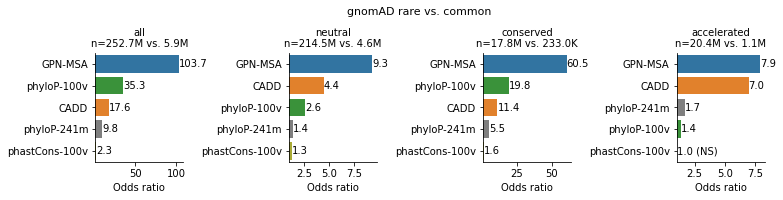

In [65]:
barplot(
    results_gnomad_strat[(results_gnomad_strat.n == 30)].sort_values(
        "Consequence",
        key=lambda x: pd.Categorical(
            x, categories=["all", "neutral", "conserved", "accelerated"]
        ),
    ),
    "Odds ratio",
    "gnomAD rare vs. common",
    ncols=4,
    wspace=1.2,
    width=3,
    y=1.2,
    # save_path="gnomad_strat_or.svg",
)

## gnomAD Enformer set (low-frequency vs. common)

In [64]:
enformer_models = dataset_models["gnomAD_Enformer"]
results_enformer = []
df_c = V_enformer.drop_nulls(subset=enformer_models)
n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
for m in tqdm(enformer_models):
    odds_ratio = get_odds_ratio(
        df_c.select(["label", pl.col(m).alias("score")]), [30, 60, 90]
    ).with_columns(Model=pl.lit(m), n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg))
    results_enformer.append(odds_ratio)
results_enformer = pl.concat(results_enformer).to_pandas()
results_enformer.head()

100%|██████████| 8/8 [00:12<00:00,  1.53s/it]


,n,Odds ratio,p_value,Model,n_pos,n_neg
0,30,3.387194,1.141404e-11,GPN-MSA,7627870,6208835
1,60,3.202563,3.226402e-19,GPN-MSA,7627870,6208835
2,90,2.848963,6.328104e-22,GPN-MSA,7627870,6208835
3,30,1.181566,2.751448e-01,CADD,7627870,6208835
4,60,0.947404,6.551777e-01,CADD,7627870,6208835


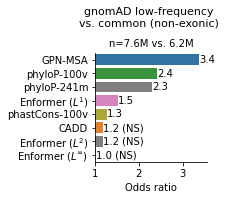

In [66]:
barplot(
    results_enformer[(results_enformer.n == 30)].replace(
        {
            "Enformer_l1": r"Enformer ($L^1$)",
            "Enformer_l2": r"Enformer ($L^2$)",
            "Enformer_linf": r"Enformer ($L^\infty$)",
        }
    ),
    "Odds ratio",
    "gnomAD low-frequency\nvs. common (non-exonic)",
    y=1.2,
    # save_path="gnomad_enformer_or.pdf",
)

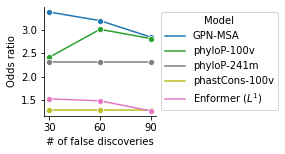

In [99]:
plt.figure(figsize=(2, 2))
g = sns.lineplot(
    data=results_enformer[results_enformer.p_value < 0.05]
    .rename(columns={"n": "# of false discoveries"})
    .replace(
        {
            "Enformer_l1": r"Enformer ($L^1$)",
            "Enformer_l2": r"Enformer ($L^2$)",
            "Enformer_linf": r"Enformer ($L^\infty$)",
        }
    ),
    x="# of false discoveries",
    y="Odds ratio",
    hue="Model",
    marker="o",
    palette=palette,
)
g.set(xticks=[30, 60, 90])
sns.despine()
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));
# plt.savefig(plot_dir + "gnomad_enformer_or_line.pdf", bbox_inches="tight")

## gnomAD ablation set (rare vs. common subsample)

In [70]:
gnomad_ablation_models = dataset_models["gnomAD_ablation"]
results_gnomad_ablation = []
df_c = V_gnomad_ablation.drop_nulls(subset=gnomad_ablation_models)
n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
for m in tqdm(gnomad_ablation_models):
    odds_ratio = get_odds_ratio(
        df_c.select(["label", pl.col(m).alias("score")]), [30, 60, 90]
    ).with_columns(Model=pl.lit(m), n_pos=pl.lit(n_pos), n_neg=pl.lit(n_neg))
    results_gnomad_ablation.append(odds_ratio)
results_gnomad_ablation = pl.concat(results_gnomad_ablation).to_pandas()
results_gnomad_ablation.head()

100%|██████████| 47/47 [00:41<00:00,  1.13it/s]


,n,Odds ratio,p_value,Model,n_pos,n_neg
0,30,41.764015,0.0,GPN-MSA,5913139,5905873
1,60,31.397468,0.0,GPN-MSA,5913139,5905873
2,90,25.725412,0.0,GPN-MSA,5913139,5905873
3,30,43.117784,0.0,multiz100way/89/128/64/True/defined.phastCons....,5913139,5905873
4,60,32.691802,0.0,multiz100way/89/128/64/True/defined.phastCons....,5913139,5905873


## Ablation study

In [75]:
results_ablation = [
    df[df.Model.isin(["GPN-MSA"] + ablation_models)]
    for df in [
        results_clinvar[["Model", "AUROC"]].rename(columns={"AUROC": "ClinVar"}),
        results_cosmic[["Model", "AUPRC"]].rename(columns={"AUPRC": "COSMIC"}),
        results_omim[results_omim.Consequence == "all"][["Model", "AUPRC"]].rename(
            columns={"AUPRC": "OMIM"}
        ),
        results_gnomad_ablation.query("n==30")[["Model", "Odds ratio"]].rename(
            columns={"Odds ratio": "gnomAD"}
        ),
    ]
]

results_ablation = reduce(
    lambda x, y: x.merge(y, on="Model", how="left"), results_ablation
).replace("GPN-MSA", original_name)
results_ablation.head()

,Model,ClinVar,COSMIC,OMIM,gnomAD
0,multiz100way/89/256/128/True/defined.phastCons...,0.969064,0.363774,0.128492,42.956620
1,multiz100way/89/128/64/True/defined.phastCons....,0.968850,0.341206,0.112723,39.249922
2,multiz100way/89/256/128/True/defined.phastCons...,0.968727,0.358015,0.120241,32.746601
3,multiz100way/89/256/128/True/defined.phastCons...,0.968660,0.375973,0.107343,38.021701
4,multiz100way/89/128/64/True/defined.phastCons....,0.968525,0.354610,0.127152,41.764015


In [76]:
results_ablation[
    [col for col in results_ablation.columns if col not in ["Model", "Ablation"]]
].corr(method="spearman")

,ClinVar,COSMIC,OMIM,gnomAD
ClinVar,1.000000,0.923913,0.495953,0.816374
COSMIC,0.923913,1.000000,0.407609,0.869912
OMIM,0.495953,0.407609,1.000000,0.433973
gnomAD,0.816374,0.869912,0.433973,1.000000


In [77]:
hparam_name = {
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Default",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/False/True/True": "w/o MSA",
    "msa_multiz100way/89": "MSA frequency (no neural net)",
    "conservation_combination": "Combined phyloP and phastCons",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/[\d]+/30000/True/True/True": "Train on 50% most conserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_1.00_0.00/medium/0.1/[\d]+/30000/True/True/True": "Train on 100% of genome",
    r"multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Include closest primates",
    r"multiz100way_mammals/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 mammals",
    r"multiz100way_vertebrates/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 vertebrates",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/False/True": "Don't upweight conserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/False": "Don't replace non-conserved",
    r"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Window size = 256",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.64": "Window size = 64",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.32": "Window size = 32",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.16": "Window size = 16",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.8": "Window size = 8",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.4": "Window size = 4",
}

results_ablation["Ablation"] = None
for k, v in hparam_name.items():
    results_ablation.loc[results_ablation.Model.str.match(k), "Ablation"] = v
results_ablation = results_ablation.dropna(subset="Ablation")
results_ablation.Ablation.value_counts()

Ablation
Window size = 256                3
Default                          3
Window size = 4                  3
Include closest primates         3
Window size = 8                  3
Train on 100% of genome          3
Train on 50% most conserved      3
Window size = 16                 3
51 mammals                       3
Don't replace non-conserved      3
51 vertebrates                   3
Window size = 32                 3
Don't upweight conserved         3
Window size = 64                 3
w/o MSA                          3
MSA frequency (no neural net)    1
Combined phyloP and phastCons    1
Name: count, dtype: int64

In [78]:
results_ablation = results_ablation.groupby("Ablation")[
    [col for col in results_ablation.columns if col not in ["Model", "Ablation"]]
].agg(
    [
        "mean",
        # "std",
        # "median",
        "max",
    ]
)
results_ablation.index.name = None
results_ablation = results_ablation.loc[hparam_name.values()]
results_ablation = results_ablation.round(3)
results_ablation

ClinVar        COSMIC          OMIM         \
                                 mean    max   mean    max   mean    max   
Default                         0.969  0.969  0.348  0.355  0.124  0.133   
w/o MSA                         0.584  0.585  0.012  0.012  0.000  0.000   
MSA frequency (no neural net)   0.950  0.950  0.270  0.270  0.031  0.031   
Combined phyloP and phastCons   0.928  0.928  0.141  0.141  0.039  0.039   
Train on 50% most conserved     0.963  0.963  0.241  0.257  0.125  0.139   
Train on 100% of genome         0.960  0.961  0.210  0.224  0.120  0.122   
Include closest primates        0.954  0.956  0.214  0.219  0.139  0.156   
51 mammals                      0.964  0.965  0.323  0.325  0.073  0.076   
51 vertebrates                  0.967  0.967  0.342  0.347  0.101  0.108   
Don't upweight conserved        0.967  0.967  0.303  0.309  0.133  0.152   
Don't replace non-conserved     0.966  0.967  0.333  0.340  0.111  0.112   
Window size = 256               0.969  0.969  0.366  0.376  0.119  0.128   
Window size = 64                0.968  0.968  0.340  0.348  0.111  0.119   
Window size = 32                0.967  0.967  0.323  0.328  0.108  0.121   
Window size = 16                0.964  0.965  0.246  0.250  0.095  0.106   
Window size = 8                 0.961  0.961  0.188  0.209  0.080  0.086   
Window size = 4                 0.942  0.943  0.131  0.155  0.052  0.053   

                               gnomAD          
                                 mean     max  
Default                        41.377  43.118  
w/o MSA                         2.773   3.093  
MSA frequency (no neural net)  15.122  15.122  
Combined phyloP and phastCons  13.919  13.919  
Train on 50% most conserved    32.116  35.286  
Train on 100% of genome        27.964  30.717  
Include closest primates       24.674  26.721  
51 mammals                     41.381  43.408  
51 vertebrates                 41.624  46.792  
Don't upweight conserved       37.094  39.991  
Don't replace non-conserved    41.853  45.213  
Window size = 256              37.908  42.957  
Window size = 64               37.478  39.522  
Window size = 32               36.664  38.866  
Window size = 16               29.203  31.623  
Window size = 8                21.159  21.943  
Window size = 4                13.457  14.789

In [80]:
print(results_ablation.to_latex(escape="latex", float_format="%.3f"))

\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{2}{r}{ClinVar} & \multicolumn{2}{r}{COSMIC} & \multicolumn{2}{r}{OMIM} & \multicolumn{2}{r}{gnomAD} \\
 & mean & max & mean & max & mean & max & mean & max \\
\midrule
Default & 0.969 & 0.969 & 0.348 & 0.355 & 0.124 & 0.133 & 41.377 & 43.118 \\
w/o MSA & 0.584 & 0.585 & 0.012 & 0.012 & 0.000 & 0.000 & 2.773 & 3.093 \\
MSA frequency (no neural net) & 0.950 & 0.950 & 0.270 & 0.270 & 0.031 & 0.031 & 15.122 & 15.122 \\
Combined phyloP and phastCons & 0.928 & 0.928 & 0.141 & 0.141 & 0.039 & 0.039 & 13.919 & 13.919 \\
Train on 50\% most conserved & 0.963 & 0.963 & 0.241 & 0.257 & 0.125 & 0.139 & 32.116 & 35.286 \\
Train on 100\% of genome & 0.960 & 0.961 & 0.210 & 0.224 & 0.120 & 0.122 & 27.964 & 30.717 \\
Include closest primates & 0.954 & 0.956 & 0.214 & 0.219 & 0.139 & 0.156 & 24.674 & 26.721 \\
51 mammals & 0.964 & 0.965 & 0.323 & 0.325 & 0.073 & 0.076 & 41.381 & 43.408 \\
51 vertebrates & 0.967 & 0.967 & 0.342 & 0.347 & 0.101 & 0.108 &

## ClinVar pathogenic vs. benign (missense)

In [8]:
models_clinvar_benign = dataset_models["ClinVar_benign"]
V_clinvar_benign = V_clinvar_benign.drop_nulls(subset=models_clinvar_benign)
n_pos, n_neg = V_clinvar_benign["label"].sum(), (~V_clinvar_benign["label"]).sum()
rows = []
for m in tqdm(models_clinvar_benign):
    y_true = V_clinvar_benign["label"]
    y_score = -V_clinvar_benign[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append(["all", m, AUROC, AUPRC, n_pos, n_neg])
results_clinvar_benign = pd.DataFrame(
    rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"]
).sort_values("AUROC", ascending=False)
results_clinvar_benign.head()

100%|██████████| 6/6 [00:00<00:00, 28.45it/s]


,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
5,all,ESM-1b,0.914224,0.904751,21275,26993
1,all,CADD,0.913639,0.877106,21275,26993
0,all,GPN-MSA,0.906944,0.876353,21275,26993
2,all,phyloP-100v,0.855577,0.808643,21275,26993
3,all,phyloP-241m,0.803965,0.704849,21275,26993


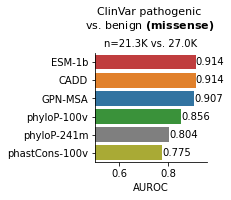

In [10]:
barplot(
    results_clinvar_benign,
    "AUROC",
    "ClinVar pathogenic\nvs. benign " + r"$\mathbf{(missense)}$",
    y=1.2,
    # save_path="clinvar_benign_auroc.svg",
)

## ClinVar pathogenic vs. benign (incl. likely)

In [8]:
models_clinvar_likely = dataset_models["ClinVar_likely"]
V_clinvar_likely = V_clinvar_likely.drop_nulls(subset=models_clinvar_likely)
n_pos, n_neg = V_clinvar_likely["label"].sum(), (~V_clinvar_likely["label"]).sum()
rows = []
for m in tqdm(models_clinvar_likely):
    y_true = V_clinvar_likely["label"]
    y_score = -V_clinvar_likely[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append(["all", m, AUROC, AUPRC, n_pos, n_neg])
results_clinvar_likely = pd.DataFrame(
    rows, columns=["Consequence", "Model", "AUROC", "AUPRC", "n_pos", "n_neg"]
).sort_values("AUROC", ascending=False)
results_clinvar_likely.head()

100%|██████████| 6/6 [00:00<00:00, 16.42it/s]


,Consequence,Model,AUROC,AUPRC,n_pos,n_neg
5,all,ESM-1b,0.913338,0.875169,44543,74251
1,all,CADD,0.908245,0.827636,44543,74251
0,all,GPN-MSA,0.905256,0.835684,44543,74251
2,all,phyloP-100v,0.854095,0.746349,44543,74251
3,all,phyloP-241m,0.799551,0.627560,44543,74251


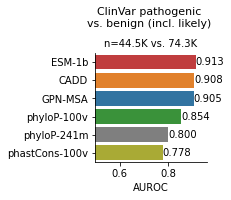

In [11]:
barplot(
    results_clinvar_likely,
    "AUROC",
    "ClinVar pathogenic\nvs. benign (incl. likely)",
    y=1.2,
    # save_path="clinvar_likely_auroc.pdf",
)

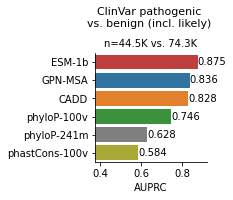

In [12]:
barplot(
    results_clinvar_likely,
    "AUPRC",
    "ClinVar pathogenic\nvs. benign (incl. likely)",
    y=1.2,
    # save_path="clinvar_likely_auprc.pdf",
)

## DMS (missense)

In [104]:
dms_renaming = {
    "A4_HUMAN_Seuma_2021": "A4_HUMAN_Seuma_2022",
    "CP2C9_HUMAN_Amorosi_abundance_2021": "CP2C9_HUMAN_Amorosi_2021_abundance",
    "CP2C9_HUMAN_Amorosi_activity_2021": "CP2C9_HUMAN_Amorosi_2021_activity",
    "P53_HUMAN_Giacomelli_NULL_Etoposide_2018": "P53_HUMAN_Giacomelli_2018_Null_Etoposide",
    "P53_HUMAN_Giacomelli_NULL_Nutlin_2018": "P53_HUMAN_Giacomelli_2018_Null_Nutlin",
    "P53_HUMAN_Giacomelli_WT_Nutlin_2018": "P53_HUMAN_Giacomelli_2018_WT_Nutlin",
    "SRC_HUMAN_Ahler_CD_2019": "SRC_HUMAN_Ahler_2019",
    "TPOR_HUMAN_Bridgford_S505N_2020": "TPOR_HUMAN_Bridgford_2020",
    "VKOR1_HUMAN_Chiasson_abundance_2020": "VKOR1_HUMAN_Chiasson_2020_abundance",
    "VKOR1_HUMAN_Chiasson_activity_2020": "VKOR1_HUMAN_Chiasson_2020_activity",
}

V_dms = V_dms.with_columns(pl.col("DMS").str.replace("DMS_", "").replace(dms_renaming))
len(V_dms["DMS"].unique())

31

In [105]:
# Fix 1 experiment
V_dms = V_dms.with_columns(
    pl.when(pl.col("DMS") == "TADBP_HUMAN_Bolognesi_2019")
    .then(-pl.col("label").abs())
    .otherwise(pl.col("label"))
)

In [106]:
#!wget https://raw.githubusercontent.com/OATML-Markslab/ProteinGym/main/reference_files/DMS_substitutions.csv
dms_metadata = (
    pl.read_csv(
        "DMS_substitutions.csv",
        columns=[
            "DMS_id",
            "DMS_binarization_cutoff",
            "DMS_binarization_method",
            "selection_assay",
            "selection_type",
            "raw_DMS_phenotype_name",
            "raw_DMS_directionality",
            "coarse_selection_type",
        ],
    )
    .rename({"DMS_id": "DMS"})
    .filter(pl.col("DMS").is_in(V_dms["DMS"].unique()))
)
dms_metadata

DMS,DMS_binarization_cutoff,DMS_binarization_method,selection_assay,selection_type,raw_DMS_phenotype_name,raw_DMS_directionality,coarse_selection_type
str,f64,str,str,str,str,i64,str
"""A4_HUMAN_Seuma…",-2.0,"""manual""","""aggregation""","""survival asses…","""nscore""",1,"""Stability"""
"""ADRB2_HUMAN_Jo…",1.859962,"""median""","""transcription …","""Receptor activ…","""0.625""",1,"""Activity"""
"""BRCA1_HUMAN_Fi…",-1.0,"""manual""","""Growth""","""Growth""","""function_score…",1,"""OrganismalFitn…"
"""CALM1_HUMAN_We…",0.87279,"""median""","""Yeast growth""","""complementatio…","""screenscore""",1,"""OrganismalFitn…"
"""CP2C9_HUMAN_Am…",0.772324,"""median""","""protein abunda…","""protein abunda…","""abundance_scor…",1,"""Expression"""
"""CP2C9_HUMAN_Am…",0.54761,"""median""","""activity, bind…","""Activity, bind…","""activity_score…",1,"""Binding"""
"""DLG4_HUMAN_Fau…",-0.560259,"""median""","""Yeast growth""","""Growth""","""fitness""",1,"""OrganismalFitn…"
"""GRB2_HUMAN_Fau…",-0.7,"""manual""","""Yeast growth""","""Growth""","""fitness""",1,"""OrganismalFitn…"
"""KCNH2_HUMAN_Ko…",58.874929,"""median""","""Voltage""","""Voltage""","""score.ave""",1,"""Activity"""


In [107]:
dms_metadata["coarse_selection_type"].value_counts()

coarse_selection_type,count
str,u32
"""Stability""",1
"""OrganismalFitn…",17
"""Binding""",2
"""Expression""",5
"""Activity""",6


In [108]:
V_dms = V_dms.join(dms_metadata, on="DMS", how="left")

In [109]:
models_dms = dataset_models["DMS"]
V_dms = V_dms.drop_nulls(subset=models_dms)
rows = []
for DMS in V_dms["DMS"].unique(maintain_order=True):
    V_c = V_dms.filter(DMS=DMS)
    for m in models_dms:
        rows.append(
            [
                DMS,
                m,
                spearmanr(V_c["label"], V_c[m])[0],
                V_c[0, "coarse_selection_type"],
                V_c[0, "raw_DMS_directionality"],
            ]
        )
results_dms = pd.DataFrame(
    rows,
    columns=["DMS", "Model", "Spearman", "Selection type", "raw_DMS_directionality"],
)
results_dms.head(6)

,DMS,Model,Spearman,Selection type,raw_DMS_directionality
0,TADBP_HUMAN_Bolognesi_2019,GPN-MSA,0.483167,OrganismalFitness,1
1,TADBP_HUMAN_Bolognesi_2019,CADD,0.430450,OrganismalFitness,1
2,TADBP_HUMAN_Bolognesi_2019,phyloP-100v,0.427771,OrganismalFitness,1
3,TADBP_HUMAN_Bolognesi_2019,phyloP-241m,-0.223525,OrganismalFitness,1
4,TADBP_HUMAN_Bolognesi_2019,phastCons-100v,0.055023,OrganismalFitness,1
5,TPOR_HUMAN_Bridgford_2020,GPN-MSA,0.355802,OrganismalFitness,1


In [110]:
V_dms.shape

(41311, 18)

In [98]:
results_dms.groupby("Model")["Spearman"].mean().sort_values(ascending=False)

Model
ESM-1b            0.437922
CADD              0.350030
GPN-MSA           0.339902
phyloP-100v       0.246231
phastCons-100v    0.157533
phyloP-241m       0.131437
Name: Spearman, dtype: float64

In [99]:
results_dms.groupby("Model")["Spearman"].median().sort_values(ascending=False)

Model
ESM-1b            0.454056
GPN-MSA           0.355802
CADD              0.354116
phyloP-100v       0.283203
phyloP-241m       0.151679
phastCons-100v    0.141818
Name: Spearman, dtype: float64

In [130]:
results_dms.groupby(
    [
        "Model",
    ]
)["Spearman"].mean().sort_values(
    ascending=False
)  # something is weird, no change after fixing the TARDBP

Model
ESM-1b            0.437922
CADD              0.350030
GPN-MSA           0.339902
phyloP-100v       0.246231
phastCons-100v    0.157533
phyloP-241m       0.131437
Name: Spearman, dtype: float64

In [135]:
results_dms.groupby(["Model", "Selection type"])[
    "Spearman"
].median().reset_index().sort_values(["Selection type", "Spearman"], ascending=False)

,Model,Selection type,Spearman
14,GPN-MSA,Stability,0.365982
9,ESM-1b,Stability,0.278928
24,phyloP-100v,Stability,0.254911
19,phastCons-100v,Stability,0.176172
4,CADD,Stability,0.158095
29,phyloP-241m,Stability,-0.040377
8,ESM-1b,OrganismalFitness,0.430538
13,GPN-MSA,OrganismalFitness,0.312569
3,CADD,OrganismalFitness,0.311006
23,phyloP-100v,OrganismalFitness,0.235520


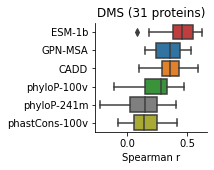

In [138]:
plt.figure(figsize=(2, 2))
g = sns.boxplot(
    data=results_dms,
    y="Model",
    x="Spearman",
    palette=palette,
    order=results_dms.groupby("Model")["Spearman"]
    .median()
    .sort_values(ascending=False)
    .index.values,
)
plt.xlabel("Spearman r")
plt.ylabel("")
plt.title("DMS (31 proteins)")
sns.despine()
# plt.savefig(plot_dir + "dms.pdf", bbox_inches="tight")

In [146]:
results_dms.groupby("Selection type").Spearman.mean().sort_values(ascending=False)

Selection type
Binding              0.384031
Expression           0.378426
Activity             0.261198
OrganismalFitness    0.246082
Stability            0.198952
Name: Spearman, dtype: float64

In [149]:
results_dms.groupby("raw_DMS_directionality").Spearman.mean().sort_values(
    ascending=False
)

raw_DMS_directionality
 1    0.288437
-1    0.241684
Name: Spearman, dtype: float64

In [141]:
ordered_results = (
    results_dms.groupby("DMS").Spearman.mean().sort_values(ascending=False)
)
ordered_results

DMS
NUD15_HUMAN_Suiter_2020                     0.502836
CP2C9_HUMAN_Amorosi_2021_activity           0.460381
CP2C9_HUMAN_Amorosi_2021_abundance          0.445203
P53_HUMAN_Giacomelli_2018_WT_Nutlin         0.439326
TPMT_HUMAN_Matreyek_2018                    0.418511
P53_HUMAN_Kotler_2018                       0.397646
ADRB2_HUMAN_Jones_2020                      0.362760
P53_HUMAN_Giacomelli_2018_Null_Etoposide    0.346751
BRCA1_HUMAN_Findlay_2018                    0.334752
SC6A4_HUMAN_Young_2021                      0.329945
VKOR1_HUMAN_Chiasson_2020_abundance         0.324206
DLG4_HUMAN_Faure_2021                       0.314030
GRB2_HUMAN_Faure_2021                       0.310479
P53_HUMAN_Giacomelli_2018_Null_Nutlin       0.309204
YAP1_HUMAN_Araya_2012                       0.307682
TPOR_HUMAN_Bridgford_2020                   0.276314
VKOR1_HUMAN_Chiasson_2020_activity          0.271635
TADBP_HUMAN_Bolognesi_2019                  0.257298
KCNH2_HUMAN_Kozek_2020                    

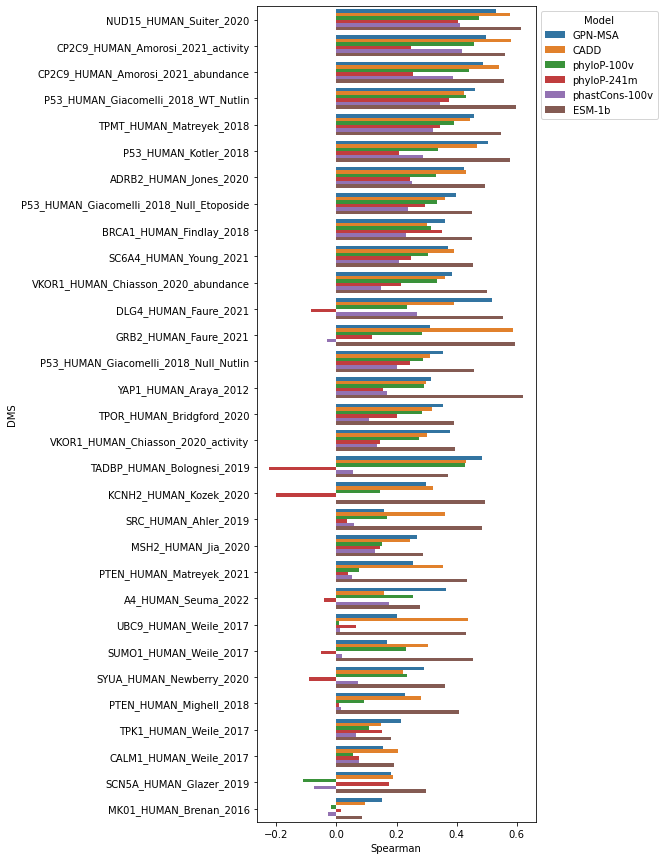

In [159]:
plt.figure(figsize=(5, 15))
g = sns.barplot(
    data=results_dms,
    y="DMS",
    hue="Model",
    x="Spearman",
    order=ordered_results.index.values,
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));

In [144]:
V_dms.filter(DMS="MK01_HUMAN_Brenan_2016").plot.scatter(
    x="label", y="GPN-MSA"
)  # should put hue=model

:Scatter   [label]   (GPN-MSA)

In [145]:
V_dms.filter(DMS="MK01_HUMAN_Brenan_2016").plot.scatter(
    x="label", y="ESM-1b"
)  # should put hue=model

:Scatter   [label]   (ESM-1b)

In [177]:
rows = []
for DMS in V_dms["DMS"].unique(maintain_order=True):
    V_c = V_dms.filter(DMS=DMS)
    if DMS == "TADBP_HUMAN_Bolognesi_2019":
        V_c = V_c.with_columns(pl.median("label").alias("DMS_binarization_cutoff"))
    V_c = V_c.with_columns(pl.col("label") <= pl.col("DMS_binarization_cutoff"))
    for m in models_dms:
        rows.append([DMS, m, roc_auc_score(V_c["label"], -V_c[m])])
results_dms = pd.DataFrame(rows, columns=["DMS", "Model", "AUROC"])
results_dms.head(6)

,DMS,Model,AUROC
0,TADBP_HUMAN_Bolognesi_2019,GPN-MSA,0.746674
1,TADBP_HUMAN_Bolognesi_2019,CADD,0.716662
2,TADBP_HUMAN_Bolognesi_2019,phyloP-100v,0.720359
3,TADBP_HUMAN_Bolognesi_2019,phyloP-241m,0.391045
4,TADBP_HUMAN_Bolognesi_2019,phastCons-100v,0.509667
5,TADBP_HUMAN_Bolognesi_2019,ESM-1b,0.683984


In [178]:
results_dms.DMS.unique().shape

(31,)

In [179]:
results_dms.groupby("Model")["AUROC"].mean().sort_values(ascending=False)

Model
ESM-1b            0.764433
CADD              0.711935
GPN-MSA           0.710491
phyloP-100v       0.653911
phyloP-241m       0.577694
phastCons-100v    0.575459
Name: AUROC, dtype: float64

In [180]:
results_dms.groupby("Model")["AUROC"].median().sort_values(ascending=False)

Model
ESM-1b            0.787541
GPN-MSA           0.720000
CADD              0.712012
phyloP-100v       0.670180
phyloP-241m       0.602065
phastCons-100v    0.547120
Name: AUROC, dtype: float64

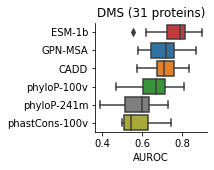

In [181]:
plt.figure(figsize=(2, 2))
g = sns.boxplot(
    data=results_dms,
    y="Model",
    x="AUROC",
    palette=palette,
    order=results_dms.groupby("Model")["AUROC"]
    .median()
    .sort_values(ascending=False)
    .index.values,
)
plt.ylabel("")
plt.title("DMS (31 proteins)")
sns.despine()

## DMS (v2)

In [114]:
dms_measurements = (
    pl.read_parquet("../../results/dms2/processed_measurements.parquet")
    .drop("mutated_sequence")
    .with_columns(
        pl.col("DMS")
        .str.split("_")
        .list.slice(0, 2)
        .list.join("_")
        .alias("uniprot_gene_name")
    )
)
dms_measurements

mutant,DMS_score,DMS_score_bin,DMS,uniprot_gene_name
str,f64,i64,str,str
"""A673C""",-1.018869,1,"""A4_HUMAN_Seuma…","""A4_HUMAN"""
"""A673D""",-0.605052,1,"""A4_HUMAN_Seuma…","""A4_HUMAN"""
"""A673E""",-0.590857,1,"""A4_HUMAN_Seuma…","""A4_HUMAN"""
"""A673E:A692E""",-2.443601,0,"""A4_HUMAN_Seuma…","""A4_HUMAN"""
"""A673E:A692T""",-3.049893,0,"""A4_HUMAN_Seuma…","""A4_HUMAN"""
"""A673E:A692V""",-1.203978,1,"""A4_HUMAN_Seuma…","""A4_HUMAN"""
"""A673E:A701T""",-0.038765,1,"""A4_HUMAN_Seuma…","""A4_HUMAN"""
"""A673E:A701V""",0.889917,1,"""A4_HUMAN_Seuma…","""A4_HUMAN"""
"""A673E:A713S""",-1.144511,1,"""A4_HUMAN_Seuma…","""A4_HUMAN"""


In [117]:
models_dms = dataset_models["DMS"]
V_dms = V_dms.drop_nulls(subset=models_dms)
# filter out synonymous
V_dms = V_dms.filter(
    (pl.col("mutant").str.slice(0, 1)) != (pl.col("mutant").str.slice(-1))
)

In [138]:
# V_dms_original = V_dms.clone()
V_dms = V_dms_original.clone()

In [139]:
V_dms = V_dms.group_by(["uniprot_gene_name", "mutant"]).agg(
    pl.col(models_dms).max()
)  # min, mean, max
V_dms

uniprot_gene_name,mutant,GPN-MSA,CADD,phyloP-100v,phyloP-241m,phastCons-100v,ESM-1b
str,str,f32,f64,f64,f64,f64,f64
"""TADBP_HUMAN""","""M1I""",-6.303711,-2.993698,-6.297,-8.71,-1.0,-14.022
"""TADBP_HUMAN""","""E3Q""",-9.637695,-3.027309,-8.737,-6.926,-1.0,-5.078
"""TADBP_HUMAN""","""I5T""",-11.027344,-3.136698,-7.775,-6.299,-1.0,-11.724
"""TADBP_HUMAN""","""R6W""",-8.394531,-3.355366,-3.623,-5.884,-1.0,-12.394
"""TADBP_HUMAN""","""T8I""",-9.595703,-3.37766,-7.667,-7.046,-1.0,-4.746
"""TADBP_HUMAN""","""D13N""",-10.12793,-3.830812,-9.698,-8.71,-1.0,-8.617
"""TADBP_HUMAN""","""S20P""",-9.953125,-3.487619,-6.041,-4.676,-1.0,-11.607
"""TADBP_HUMAN""","""E21Q""",-11.179688,-3.730953,-9.698,-2.946,-1.0,-8.212
"""TADBP_HUMAN""","""D22A""",-11.730469,-3.334192,-9.042,-6.274,-1.0,-9.255


In [140]:
dms_measurements.shape, V_dms.shape

((485830, 5), (82703, 8))

In [141]:
V_dms = dms_measurements.join(V_dms, how="inner", on=["uniprot_gene_name", "mutant"])
V_dms

mutant,DMS_score,DMS_score_bin,DMS,uniprot_gene_name,GPN-MSA,CADD,phyloP-100v,phyloP-241m,phastCons-100v,ESM-1b
str,f64,i64,str,str,f32,f64,f64,f64,f64,f64
"""A673E""",-0.590857,1,"""A4_HUMAN_Seuma…","""A4_HUMAN""",-10.566406,-3.230359,-6.549,-8.792,-1.0,-5.178
"""A673G""",0.268496,1,"""A4_HUMAN_Seuma…","""A4_HUMAN""",-9.066406,-3.369089,-6.549,-8.792,-1.0,-4.395
"""A673P""",-0.384103,1,"""A4_HUMAN_Seuma…","""A4_HUMAN""",-8.933594,-3.127155,-2.928,-5.022,-1.0,-2.478
"""A673S""",-0.522624,1,"""A4_HUMAN_Seuma…","""A4_HUMAN""",-6.797607,-2.205392,-2.928,-5.022,-1.0,-2.343
"""A673T""",0.183441,1,"""A4_HUMAN_Seuma…","""A4_HUMAN""",-6.858887,-2.307512,-2.928,-5.022,-1.0,-2.613
"""A673V""",-1.125238,1,"""A4_HUMAN_Seuma…","""A4_HUMAN""",-8.824219,-3.028971,-6.549,-8.792,-1.0,-3.128
"""A692E""",-0.705952,1,"""A4_HUMAN_Seuma…","""A4_HUMAN""",-11.40625,-3.663889,-7.672,-8.788,-1.0,-14.193
"""A692G""",0.304646,1,"""A4_HUMAN_Seuma…","""A4_HUMAN""",-10.453125,-3.59739,-7.672,-8.788,-1.0,-10.342
"""A692P""",-0.760732,1,"""A4_HUMAN_Seuma…","""A4_HUMAN""",-9.546875,-3.219298,-4.614,-7.128,-1.0,-11.938


In [142]:
# Fix 1 experiment
V_dms = V_dms.with_columns(
    pl.when(pl.col("DMS") == "TADBP_HUMAN_Bolognesi_2019")
    .then(-pl.col("DMS_score").abs())
    .otherwise(pl.col("DMS_score"))
)

In [143]:
V_dms = V_dms.filter(pl.col("DMS").is_in(V_dms_old["DMS"].unique()))

In [144]:
rows = []
for DMS in V_dms["DMS"].unique(maintain_order=True):
    V_c = V_dms.filter(DMS=DMS)
    for m in models_dms:
        rows.append(
            [
                DMS,
                m,
                spearmanr(V_c["DMS_score"], V_c[m])[0],
            ]
        )
results_dms = pd.DataFrame(rows, columns=["DMS", "Model", "Spearman"])
results_dms.head(6)

,DMS,Model,Spearman
0,A4_HUMAN_Seuma_2022,GPN-MSA,0.346963
1,A4_HUMAN_Seuma_2022,CADD,0.181012
2,A4_HUMAN_Seuma_2022,phyloP-100v,0.265744
3,A4_HUMAN_Seuma_2022,phyloP-241m,-0.046604
4,A4_HUMAN_Seuma_2022,phastCons-100v,0.168434
5,A4_HUMAN_Seuma_2022,ESM-1b,0.237464


In [145]:
results_dms["DMS"].unique().shape

(31,)

In [146]:
results_dms.groupby("Model")["Spearman"].agg(["mean", "median"])

,mean,median
Model,,
CADD,0.349900,0.357240
ESM-1b,0.434333,0.450761
GPN-MSA,0.338090,0.346963
phastCons-100v,0.155177,0.136605
phyloP-100v,0.245694,0.278436
phyloP-241m,0.137493,0.151980


In [79]:
results_dms.groupby("Model")["Spearman"].mean().sort_values(ascending=False)

Model
ESM-1b            0.434333
CADD              0.350542
GPN-MSA           0.337068
phyloP-100v       0.244540
phastCons-100v    0.156658
phyloP-241m       0.133354
Name: Spearman, dtype: float64

In [80]:
results_dms.groupby("Model")["Spearman"].median().sort_values(ascending=False)

Model
ESM-1b            0.450761
CADD              0.355494
GPN-MSA           0.342154
phyloP-100v       0.281835
phyloP-241m       0.146748
phastCons-100v    0.138508
Name: Spearman, dtype: float64

In [83]:
V_dms.shape

(41679, 11)

In [86]:
# V_dms.to_pandas().to_csv("DMS_v2.csv.gz", index=False)

## Gene essentiality prediction

In [5]:
results_essentiality = (
    pl.read_parquet(
        "/scratch/users/czye/GPN/genome_wide_eda/depmap_cls_performance_v3.1.parquet"
    )
    .rename({"__index_level_0__": "Model"})
    .drop("AUROC")
    .with_columns(
        pl.col("Model").replace(
            {
                "GPN-MSA_combine_types": "GPN-MSA",
                "CADD-Raw_combine_types": "CADD",
                "PhyloP100Way_combine_types": "phyloP-100v",
                "PhyloP241Way_combine_types": "phyloP-241m",
                "pLI_v4": "pLI",
                "hs_log10_map": r"$hs$",
                "s_het_post_mean": "GeneBayes",
            }
        ),
        pl.lit(508).alias("n_pos"),
        pl.lit(2815).alias("n_neg"),
    )
    .sort("AUPRC", descending=True)
)
results_essentiality

AUPRC,Model,n_pos,n_neg
f64,str,i32,i32
0.517557,"""GPN-MSA""",508,2815
0.435588,"""GeneBayes""",508,2815
0.434455,"""CADD""",508,2815
0.409551,"""phyloP-100v""",508,2815
0.319358,"""phyloP-241m""",508,2815
0.31633,"""pLI""",508,2815
0.307142,"""$hs$""",508,2815


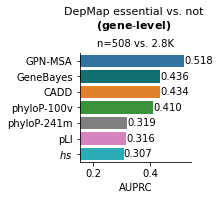

In [7]:
barplot(
    results_essentiality.to_pandas(),
    "AUPRC",
    "DepMap essential vs. not\n" + r"$\mathbf{(gene}$" + "-" + r"$\mathbf{level)}$",
    y=1.2,
    # save_path="essentiality_auprc.svg",
)